# Classification test

In [52]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [53]:
df = pd.read_csv("data/BTCUSDT-hour-target-features.csv")
# df = pd.read_csv("data/modelv1_training_data.csv")

# dfd = pd.read_csv("data/classification_test.csv")

In [54]:
# df1 = pd.concat([df, dfd[list(dfd.columns)[9:-2]]], axis=1)
# df1.columns
df.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore', 'target',
       'mom_ao_10_log', 'mom_ppo_10_signal_log', 'mom_ppo_30_hist',
       'mom_roc_50_log', 'mom_rsi_30', 'mom_sr_9_signal', 'mom_srsi_15_k',
       'mom_srsi_30', 'mom_srsi_10_d', 'mom_tsi_20_log', 'mom_wr_50',
       'trend_adx_40_neg', 'trend_arn_50', 'trend_cci_70', 'trend_dpo_100_log',
       'trend_kst_sig_log', 'trend_macd_12_signal_log',
       'trend_sma_50_rate_log', 'trend_sma_50_diff_log',
       'trend_sma_200_diff_o_close_log', 'trend_stc_50_2', 'trend_trix_20_log',
       'trend_vi_50_amp', 'volatility_atr_14', 'volatility_atr_o_close',
       'volatility_bb_wband_10', 'volatility_bb_pband_100',
       'volatility_bb_wband_200', 'volatility_bb_hband_o_close',
       'volatility_dc_pband_50', 'volatility_dc_wband_10',
       'volatility_pband_50', 'volatility_wband_20', 'volatility_ui_30',
       'volume_cmf_50', 'volum

In [76]:
indicators = list(df.columns)[13:]
indicators.append("target")

d = df.copy()
d.dropna(inplace=True)
close = d["close"][29000:]

d = d[list(indicators)].copy().astype(np.float32)

X = d.drop(["target", "close"], axis=1, errors="ignore")[:29000]
y = d["target"][:29000]

X_ft = d.drop(["target", "close"], axis=1, errors="ignore")[29000:]
y_ft = d["target"][29000:]

In [77]:
# X_ft_c = X_ft.copy()
# X_ft_c["close"] = close
# X_ft_c.to_csv("data/modelv1.1_testing.csv", index=False)

In [78]:
X_ft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3028 entries, 29458 to 32535
Data columns (total 40 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   mom_ao_10_log                   3028 non-null   float32
 1   mom_ppo_10_signal_log           3028 non-null   float32
 2   mom_ppo_30_hist                 3028 non-null   float32
 3   mom_roc_50_log                  3028 non-null   float32
 4   mom_rsi_30                      3028 non-null   float32
 5   mom_sr_9_signal                 3028 non-null   float32
 6   mom_srsi_15_k                   3028 non-null   float32
 7   mom_srsi_30                     3028 non-null   float32
 8   mom_srsi_10_d                   3028 non-null   float32
 9   mom_tsi_20_log                  3028 non-null   float32
 10  mom_wr_50                       3028 non-null   float32
 11  trend_adx_40_neg                3028 non-null   float32
 12  trend_arn_50                 

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [80]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

Text(-1.5, 0.5, 'Predicted label')

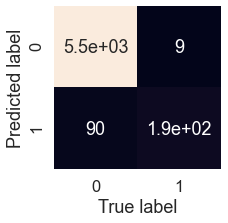

In [81]:
y_preds = model.predict(X_test)	

sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(3, 3))
ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                 annot=True,
                 cbar=False)
plt.xlabel("True label")
plt.ylabel("Predicted label")

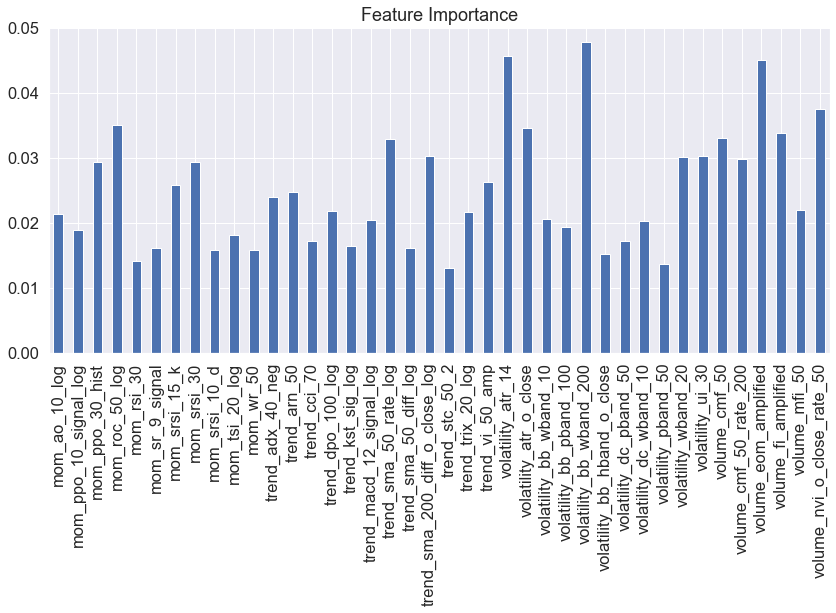

In [82]:
feature_dict = dict(zip(X_train.columns, list(model.feature_importances_)))
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title="Feature Importance", legend=False, figsize=(14, 6));

In [85]:
d = {}
d["precision"] = np.mean(cross_val_score(model, X, y, cv=5, scoring='precision'))
d

/Volumes/Storage/Programming/bitcoin-printer/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'precision': 0.10869868226895549}

In [86]:
d["recall"] = np.mean(cross_val_score(model, X, y, cv=5, scoring='recall'))
d

{'precision': 0.10869868226895549, 'recall': 0.15982013144240748}

In [87]:
d["f1"] = np.mean(cross_val_score(model, X, y, cv=5, scoring='f1'))
d

{'precision': 0.10869868226895549,
 'recall': 0.15982013144240748,
 'f1': 0.09151980977413658}

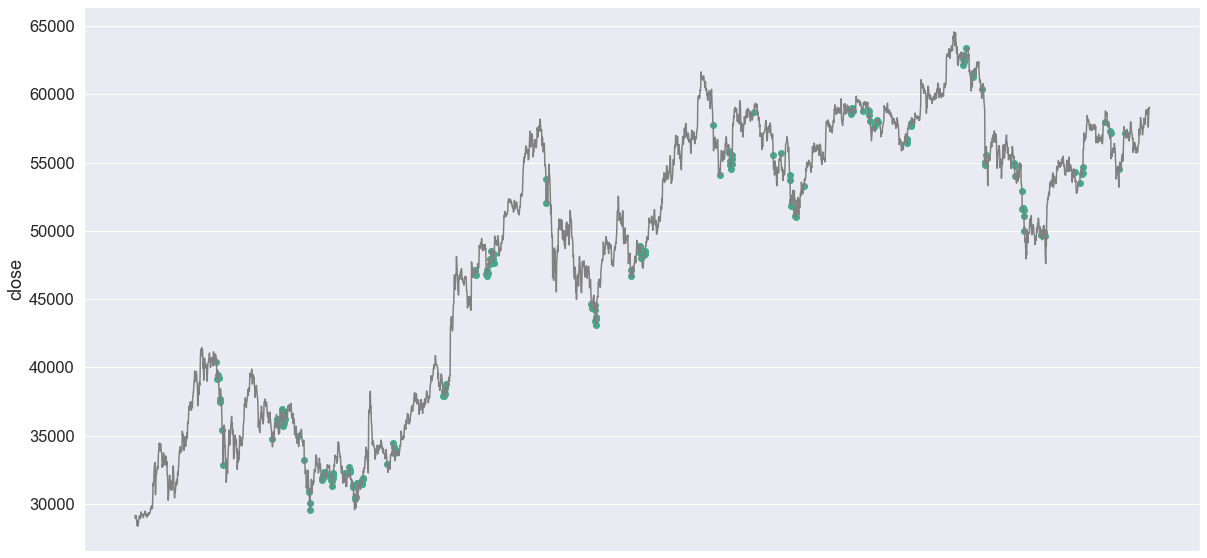

In [68]:
results = model.predict(X_ft)
scatter_results = list(map(lambda x, c: c if x == 1 else None, results, close))

s_correct = list(map(lambda x, t, c: c if x == 1 and t == 1 else None, results, y_ft, close))
s_wrong = list(map(lambda x, t, c: c if x == 1 and t == 0 else None, results, y_ft, close))
s_missed = list(map(lambda x, t, c: c if x == 0 and t == 1 else None, results, y_ft, close))

fig,ax = plt.subplots(figsize=(20, 10))

rows = len(close)
ax.scatter(range(rows), 
            scatter_results,
            color="#43aa8b")


# ax.scatter(range(rows), 
#             s_missed,
#         color="#f9c74f")

# ax.scatter(range(rows), 
#             s_correct,
#         color="#43aa8b")

# ax.scatter(range(rows), 
#             s_wrong,
#         color="#f94144")

ax.set_xlabel("time")
ax.set_ylabel("close")
ax.plot(range(rows),
        close,
        color="gray")

ax.tick_params(labelbottom=False)
ax.axes.xaxis.set_visible(False)

In [48]:
from joblib import dump, load

In [49]:
dump(model, 'models/model_v1.1.joblib') 

['models/model_v1.1.joblib']